# LLM as a judge for Transcripts (Doctor and Patient Chatbots) - version 2.1

Some improvements to tackle:
- use 4o-mini (cheaper)
- make sure that transcript-judge works for reluctant patient. As in, if patient is holding back information without the doctor bot probing further for more information, we should penalize the score.

In [54]:
import time
import json
from pprint import pprint

import pandas as pd
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage
from dotenv import load_dotenv

# Load API keys from .env file
load_dotenv()

# pandas settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 300)

In [3]:
# Create the ChatOpenAI model instance

# model_name = "gpt-3.5-turbo-0125"  # release date: 2024-01-25
# model_name = "gpt-3.5-turbo-1106"  # release date: 2023-11-06
# model_name = "gpt-4o-2024-05-13"  # release date: 2024-05-13
model_name = "gpt-4o-mini"  # release date: 2024-07-18

model = ChatOpenAI(temperature=0.0, model_name=model_name)

## System Prompt

In [4]:
# Define the system message for the evaluation

symptom_ask_description = "Did the DOCTOR ask about '{symptom}' and was successful in getting a confirmation from PATIENT on whether the PATIENT experiences it?"

judge_criteria = {
    # introduction
    "patient_name": "Was the PATIENT's name mentioned by the DOCTOR?",

    # symptoms
    "dyspnea": symptom_ask_description.format(symptom="dyspnea (shortness of breath) at rest, while walking or climbing stairs"),
    "pnd": symptom_ask_description.format(symptom="paroxysmal nocturnal dyspnea (PND) (sudden shortness of breath at night)"),
    "orthopnea": symptom_ask_description.format(symptom="orthopnea (shortness of breath while lying flat)"),
    "ankle_edema": symptom_ask_description.format(symptom="ankle edema or general lower extremity swelling (swelling in ankles or legs)"),
    "nocturnal_cough": symptom_ask_description.format(symptom="nocturnal cough (coughing at night)"),
    "chest_pain": symptom_ask_description.format(symptom="chest pain"),
    "fatigue": symptom_ask_description.format(symptom="fatigue"),
    "worsening_mental_status": symptom_ask_description.format(symptom="worsening mental status that is acute (sudden confusion or mental changes)"),

    # medications
    "doctor_ask_medications": "Did the DOCTOR ask the PATIENT what medications they are on?",

    # vitals
    "temperature": "Did the DOCTOR ask for the PATIENT's temperature/body temperature?",
    "heart_rate": "Did the DOCTOR ask for the PATIENT's heart rate (pulse)?",
    "respiratory_rate": "Did the DOCTOR ask for the PATIENT's respiratory rate (number of breaths per minute)?",
    "oxygen_saturation": "Did the DOCTOR ask for the PATIENT's oxygen saturation (oxygen level in the blood)?",
    "blood_pressure": "Did the DOCTOR ask for the PATIENT's blood pressure (systolic and diastolic / upper and lower blood pressure numbers)?",
    "weight": "Did the DOCTOR ask for the PATIENT's weight (body weight)?",

    # hcp_quality
    "sympathetic_patient": "Was the DOCTOR sympathetic when the PATIENT reported symptoms or pain?",
    "reminder": "Did the DOCTOR remind the PATIENT to contact their healthcare provider if they notice any significant changes or worsening of symptoms?",
    "end_conversation": "Did the DOCTOR express care and encourage the PATIENT to reach out if they need further assistance at the end of the conversation?",
    "natural_conversation": "Did the conversation flow naturally without repetition?",
    "no_premature_end": "The conversation ended properly without a premature end.",

    # patient_quality
    "plain_language": "Did the PATIENT use plain language?",
    "consistent_symptoms": "Was the PATIENT consistent about their symptoms?",
    "no_confabulations": "Did the PATIENT avoid inventing information that contradicts the prompt (confabulations)?",
    "allow_doctor_questions": "Did the PATIENT allow the DOCTOR to ask questions and not take over the direction of the conversation (offering information before it’s asked for)?",
}

system_message_summary_judge = """You are evaluating a dialogue TRANSCRIPT generated by a DOCTOR chatbot and a PATIENT LLM bot, based on a set of criteria.
Your evaluation will consist of answering specific questions about the DOCTOR/PATIENT bot with 1 (Yes) and 0 (No) responses.
The DOCTOR bot quality should not depend on the PATIENT.
The PATIENT bot quality however does depend on its own prompt (PATIENT_PROMPT).
{output_format}

CRITERIA (column name, then a description):
""" + "\n".join([f"'{k}': {v}" for k, v in judge_criteria.items()])

output_csv_format = """Generate a CSV row with the appropriate 1 or 0 for each criteria in the order specified below."""

output_reasoning_format = """FORMAT: In separate lines, do the following:
1. first, state the criteria you're evaluating
2. second, make a brief assessment of the criteria on the TRANSCRIPT to justify your decision
3. third, state each criteria's value (1 or 0). When explaining your assessment/reasoning
Additionally, if there are issues that result in a 0, be very specific in your assessment portion and please refer to texts in the TRANSCRIPT that is the offender. If it's a 1 (yes), keep your assessment very short.
Lastly, after all criterias are evaluated, in one last new line, please provide any short additional observations or suggestions for improvement (2 sentences), but do not repeat evaluation points previously made.
For example:

patient_name,"The DOCTOR greeted the PATIENT by name; criteria passed hence the score is 1",1
dyspnea,"The DOCTOR was successful in getting a confirmation from the PATIENT that they don't have dyspnea or shortness of breath; criteria passed hence the score is 1",1
pnd,"The DOCTOR did not ask about PND in the conversation; criteria failed hence the score is 0",0
sympathetic_patient,"The DOCTOR ignored PATIENT after PATIENT writes 'I am feeling light-headed'; criteria failed hence the score is 0",0
consistent_symptoms,"The PATIENT says 'I have chest pain' but later says 'I have no chest pain'; criteria failed hence the score is 0",0
OBSERVATION:write your two-sentence observation/improvement here
"""

human_message_summary_judge = """
PATIENT_PROMPT: {patient_prompt}

TRANSCRIPT: {transcript}
"""

In [6]:
pprint(system_message_summary_judge.format(output_format=output_reasoning_format), width=120)

('You are evaluating a dialogue TRANSCRIPT generated by a DOCTOR chatbot and a PATIENT LLM bot, based on a set of '
 'criteria.\n'
 'Your evaluation will consist of answering specific questions about the DOCTOR/PATIENT bot with 1 (Yes) and 0 (No) '
 'responses.\n'
 'The DOCTOR bot quality should not depend on the PATIENT.\n'
 'The PATIENT bot quality however does depend on its own prompt (PATIENT_PROMPT).\n'
 'FORMAT: In separate lines, do the following:\n'
 "1. first, state the criteria you're evaluating\n"
 '2. second, make a brief assessment of the criteria on the TRANSCRIPT to justify your decision\n'
 "3. third, state each criteria's value (1 or 0). When explaining your assessment/reasoning\n"
 'Additionally, if there are issues that result in a 0, be very specific in your assessment portion and please refer '
 "to texts in the TRANSCRIPT that is the offender. If it's a 1 (yes), keep your assessment very short.\n"
 'Lastly, after all criterias are evaluated, in one last new line, 

## Import Transcript

In [38]:
# Specify the path to your JSON file
base_path = "../../data/transcripts/"

transcripts_cooperative_path = base_path + "transcripts_short_gpt4o-m_basepat_imprdoc_2607.json"
with open(transcripts_cooperative_path, 'r') as json_file:
    transcripts_cooperative = json.load(json_file)

transcripts_reluctant_path = base_path + "transcripts_short_gpt4o-m_rel3pat_basedoc_2607.json"
with open(transcripts_reluctant_path, 'r') as json_file:
    transcripts_reluctant = json.load(json_file)

# note: we're not saving evaluations just yet, until transcript judge is in its final form

# -----
# for testing only; comment when not needed -- only try to generate one transcript's evaluation per type of patient
cooperative_patient_idx = "10320090"
single_cooperative_patient = transcripts_cooperative[cooperative_patient_idx]
single_cooperative_patient_transcript = single_cooperative_patient["chat_transcript"]
single_cooperative_patient_prompt = single_cooperative_patient["prompt"]

reluctant_patient_idx = "18087161"
single_reluctant_patient = transcripts_reluctant[reluctant_patient_idx]
single_reluctant_patient_transcript = single_reluctant_patient["chat_transcript"]
single_reluctant_patient_prompt = single_reluctant_patient["prompt"]
# -----

In [110]:
# Specify the path to your JSON file
base_path = "../../data/transcripts/"

transcripts_filenames = {
    "cooperative_basedoc": "transcripts_short_gpt4o-m_basepat_basedoc_2307.json",
    "cooperative_imprdoc": "transcripts_short_gpt4o-m_basepat_imprdoc_2607.json",
    "reluctant_basedoc": "transcripts_short_gpt4o-m_rel3pat_basedoc_2607.json",
    "reluctant_imprdoc": "transcripts_short_gpt4o-m_rel3pat_imprdoc_2607.json",
}
all_transcripts = {}
for patient_type, path in transcripts_filenames.items():
    with open(base_path + path, 'r') as json_file:
        all_transcripts[patient_type] = json.load(json_file)

In [111]:
def parse_response(response_content: str):
    """
    Function to validate and parse the response.

    Example response
     'intro_patient,1,""\n'
     'current_symptoms,1,""\n'
     'symptoms_agree,0,"Nose bleeding was mentioned in the summary, but not in the transcript."\n'

    Desired output
    {"intro_patient": {"value": 1, "reasoning": ""}, "current_symptoms": {"value": 1, "reasoning": ""}, ...}
    """
    response_list = response_content.split("\n")
    response_dict = {}
    for response in response_list:
        if response:
            try:
                (criteria, back_split) = response.split(",", 1)
                (reasoning, value) = back_split.rsplit(",", 1)
                response_dict[criteria] = {"value": int(value), "reasoning": reasoning.strip('"')}
            except ValueError:
                # print(f"Error parsing response: {response}")
                pass

    # additional wrangling on all: find phrase 'criteria passed hence the score is 1' and 'criteria failed hence the score is 0'
    # if found, override the value with 1 or 0
    for key, value in response_dict.items():
        if "criteria passed hence the score is 1" in value["reasoning"]:
            response_dict[key]["value"] = 1
        elif "criteria failed hence the score is 0" in value["reasoning"]:
            response_dict[key]["value"] = 0

    # find a line that starts with 'observation:' and use it as the observation
    response_dict["observations"] = ""
    for line in response_content.split("\n"):
        if line.lower().startswith("observation:"):
            response_dict["observations"] = line.split(":", 1)[1].strip()
            break

    return response_dict

In [ ]:
all_rows_series: list[pd.Series] = []
all_responses: dict = {}  # key: "{patient_type}_{patient_id}", value: response

In [118]:
# Execute evaluation for all transcripts

start_time = time.time()

# hack if we need to continue from a certain point
# start_time -= 1054.28

column_order = ["patient_type", "id", "name", "filename"]
for criteria in judge_criteria.keys():
    column_order.append(criteria)
    column_order.append(f"{criteria}_reasoning")
column_order.append("observations")

# Loop through each patient type
for patient_type, patient_type_data in all_transcripts.items():
    print(f"Evaluating {patient_type} patient transcripts: ", end="")

    # patient_type_data is a dict with keys as patient IDs and values as patient data
    # Loop through each transcript number, invoke the model, and write the results
    for i, (patient_id, patient_data) in enumerate(patient_type_data.items()):
        try:
            transcript = patient_data['chat_transcript']
            patient_prompt = patient_data['prompt']
        except KeyError:  # not a real patient
            continue

        print(".", end="")
        if (i + 1) % 5 == 0:
            print("|", end="")

        # skip if already evaluated
        if f"{patient_type}_{patient_id}" in all_responses:
            continue

        prompt = (
            SystemMessage(content=system_message_summary_judge.format(output_format=output_reasoning_format))
            + human_message_summary_judge
        )

        # Get the response
        response = model.invoke(
            prompt.format_messages(transcript=transcript, patient_prompt=patient_prompt)
        )
        all_responses[f"{patient_type}_{patient_id}"] = response
        response_dict = parse_response(response.content)

        # add to dataframe
        row_to_add = {
            "patient_type": patient_type,
            "id": patient_data["id"],
            "name": patient_data["name"],
            "filename": transcripts_filenames[patient_type],
            **{k: v["value"] for k, v in response_dict.items() if k in judge_criteria.keys()},
            **{f"{k}_reasoning": v["reasoning"] for k, v in response_dict.items() if k in judge_criteria.keys()},
            "observations": response_dict["observations"]
        }
        all_rows_series.append(pd.Series(row_to_add))

    print("")

total_time = time.time() - start_time
print(f"\n\nTime taken to evaluate {len(all_rows_series)} transcripts: {total_time:.2f} seconds ({total_time / len(all_rows_series):.2f} seconds per transcript)")

# create dataframe
df = pd.DataFrame(all_rows_series)[column_order]
display(df.sample(10))

Evaluating cooperative_basedoc patient transcripts: .....|.....|.....|.....|
Evaluating cooperative_imprdoc patient transcripts: .....|.....|.....|.....|
Evaluating reluctant_basedoc patient transcripts: .....|.....|.....|.....|
Evaluating reluctant_imprdoc patient transcripts: .....|.....|.....|.....|


Time taken to evaluate 80 transcripts: 1054.29 seconds (13.18 seconds per transcript)


,patient_type,id,name,filename,patient_name,patient_name_reasoning,dyspnea,dyspnea_reasoning,pnd,pnd_reasoning,orthopnea,orthopnea_reasoning,ankle_edema,ankle_edema_reasoning,nocturnal_cough,nocturnal_cough_reasoning,chest_pain,chest_pain_reasoning,fatigue,fatigue_reasoning,worsening_mental_status,worsening_mental_status_reasoning,doctor_ask_medications,doctor_ask_medications_reasoning,temperature,temperature_reasoning,heart_rate,heart_rate_reasoning,respiratory_rate,respiratory_rate_reasoning,oxygen_saturation,oxygen_saturation_reasoning,blood_pressure,blood_pressure_reasoning,weight,weight_reasoning,sympathetic_patient,sympathetic_patient_reasoning,reminder,reminder_reasoning,end_conversation,end_conversation_reasoning,natural_conversation,natural_conversation_reasoning,no_premature_end,no_premature_end_reasoning,plain_language,plain_language_reasoning,consistent_symptoms,consistent_symptoms_reasoning,no_confabulations,no_confabulations_reasoning,allow_doctor_questions,allow_doctor_questions_reasoning,observations
11,cooperative_basedoc,10578325,Ralph Barnes,transcripts_short_gpt4o-m_basepat_basedoc_2307.json,1,The DOCTOR greeted the PATIENT by name; criteria passed hence the score is 1,1,The DOCTOR successfully confirmed the PATIENT experiences shortness of breath; criteria passed hence the score is 1,1,The DOCTOR asked about PND and received a confirmation that the PATIENT does not experience it; criteria passed hence the score is 1,1,The DOCTOR asked about orthopnea and received a confirmation that the PATIENT does not experience it; criteria passed hence the score is 1,1,The DOCTOR asked about ankle edema and received a confirmation that the PATIENT experiences it; criteria passed hence the score is 1,1,The DOCTOR asked about nocturnal cough and received a confirmation that the PATIENT does not experience it; criteria passed hence the score is 1,1,The DOCTOR asked about chest pain and received a confirmation that the PATIENT does not experience it; criteria passed hence the score is 1,1,The DOCTOR asked about fatigue and received a confirmation that the PATIENT feels more tired than usual; criteria passed hence the score is 1,1,The DOCTOR asked about worsening mental status and received a confirmation that the PATIENT's mind feels clear; criteria passed hence the score is 1,1,The DOCTOR asked the PATIENT about their current medications; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's temperature and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's heart rate and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's respiratory rate and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's oxygen saturation and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's blood pressure and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's weight and received a response; criteria passed hence the score is 1,1,The DOCTOR expressed understanding and empathy towards the PATIENT's symptoms; criteria passed hence the score is 1,0,The DOCTOR did not remind the PATIENT to contact their healthcare provider if they notice any significant changes or worsening of symptoms; criteria failed hence the score is 0,0,The DOCTOR did not express care and encourage the PATIENT to reach out if they need further assistance at the end of the conversation; criteria failed hence the score is 0,1,The conversation flowed naturally without repetition; criteria passed hence the score is 1,1,The conversation ended properly without a premature end; criteria passed hence the score is 1,1,The PATIENT used plain language throughout the conversation; criteria passed hence the score is 1,1,The PATIENT was consistent about their symptoms; criteria passed hence the score is 1,1,The PATIENT did not invent information that contradict

In [119]:
# save
df.to_csv("2.1_llm_judge_transcript_results.csv", index=False)

In [94]:
# An example of a parsed response
parse_response(all_responses["cooperative_basedoc_11280189"].content)

{'patient_name': {'value': 1,
  'reasoning': 'The DOCTOR greeted the PATIENT by name; criteria passed hence the score is 1'},
 'dyspnea': {'value': 1,
  'reasoning': 'The DOCTOR successfully asked about dyspnea and received a confirmation from the PATIENT that they do not experience it; criteria passed hence the score is 1'},
 'pnd': {'value': 1,
  'reasoning': 'The DOCTOR asked about PND and received a confirmation from the PATIENT that they do not experience it; criteria passed hence the score is 1'},
 'orthopnea': {'value': 1,
  'reasoning': 'The DOCTOR asked about orthopnea and received a confirmation from the PATIENT that they do not experience it; criteria passed hence the score is 1'},
 'ankle_edema': {'value': 1,
  'reasoning': 'The DOCTOR asked about ankle edema and received a confirmation from the PATIENT about some swelling; criteria passed hence the score is 1'},
 'nocturnal_cough': {'value': 1,
  'reasoning': 'The DOCTOR asked about nocturnal cough and received a confirmat

In [75]:
# what's an average response resource usage?
pprint(all_responses["cooperative_basedoc_11280189"].response_metadata, width=120)

{'finish_reason': 'stop',
 'logprobs': None,
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_0f03d4f0ee',
 'token_usage': {'completion_tokens': 865, 'prompt_tokens': 2749, 'total_tokens': 3614}}


In [113]:
# what's the total resource usage? For 4o-mini
prompt_cost = 0.15 / 1e6  # $0.15 per 1M tokens
completion_cost = 0.60 / 1e6  # $0.60 per 1M tokens

total_prompt_tokens = sum([r.response_metadata["token_usage"]["prompt_tokens"] for r in all_responses.values()])
total_completion_tokens = sum([r.response_metadata["token_usage"]["completion_tokens"] for r in all_responses.values()])

print(f"Total prompt tokens: {total_prompt_tokens}, cost: ${(total_prompt_cost := total_prompt_tokens * prompt_cost):0.3f}, average: {total_prompt_tokens / len(all_responses)} tokens per response")
print(f"Total completion tokens: {total_completion_tokens}, cost: ${(total_completion_cost := total_completion_tokens * completion_cost):0.3f}, average: {total_completion_tokens / len(all_responses)} tokens per response")
print(f"Total cost: ${total_prompt_cost + total_completion_cost:0.3f}")

Total prompt tokens: 298475, cost: $0.045, average: 3730.9375 tokens per response
Total completion tokens: 68028, cost: $0.041, average: 850.35 tokens per response
Total cost: $0.086


### Some stats

/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_70876/3942292201.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("patient_type")[list(judge_criteria.keys())].mean().T.plot(kind="bar", figsize=(25, 5), color=colors)


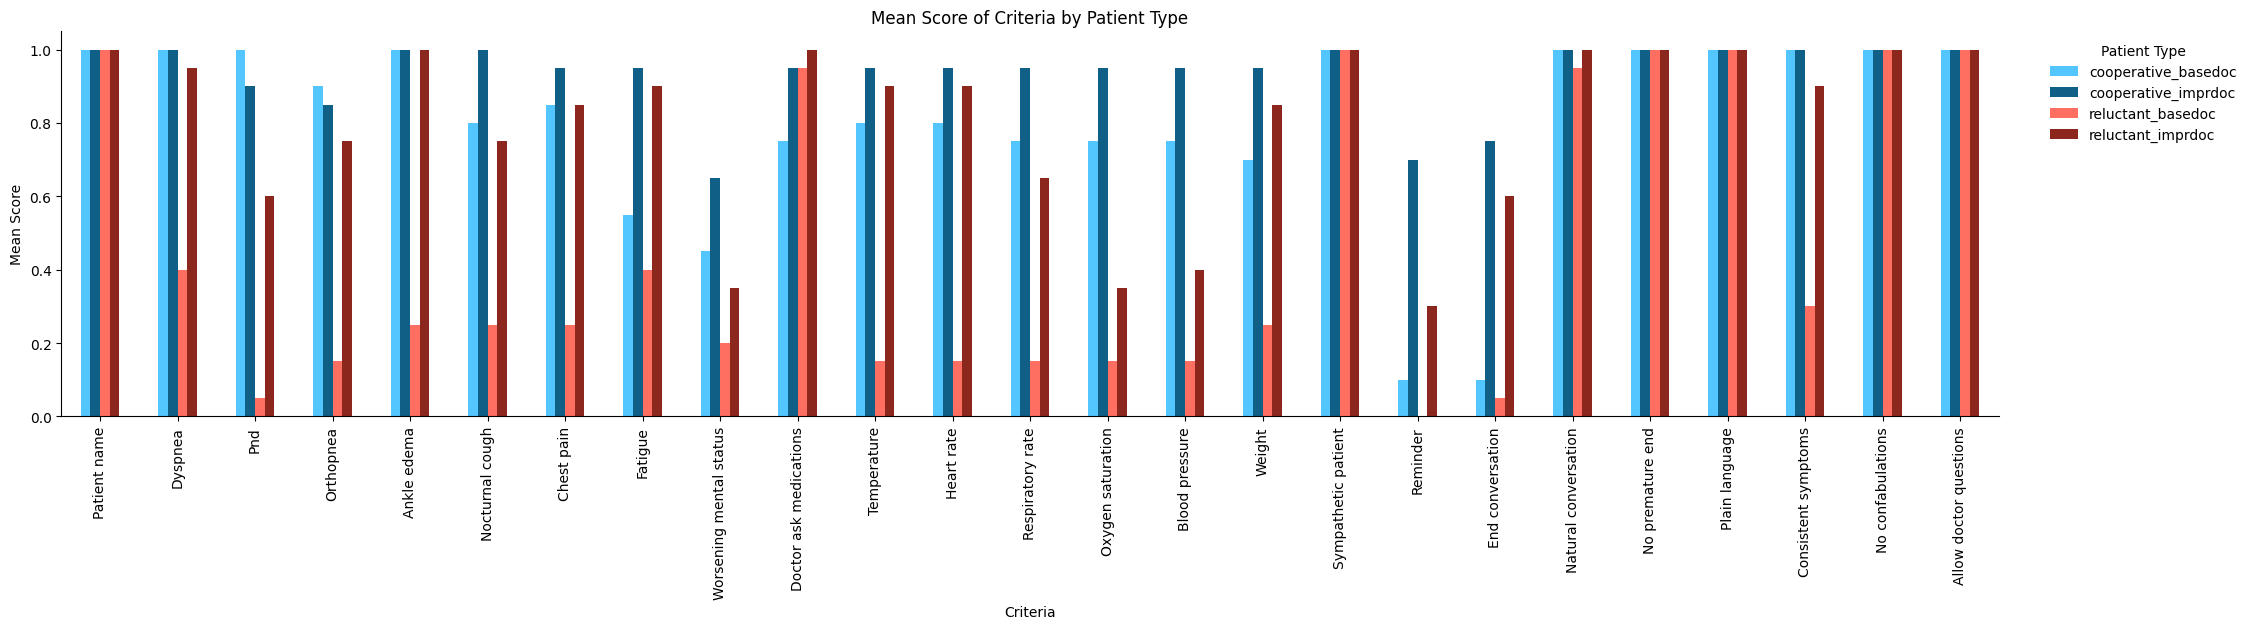

In [127]:
df = pd.read_csv("2.1_llm_judge_transcript_results.csv")  # load the saved file

df.groupby("patient_type")[list(judge_criteria.keys())].mean()

# plot bar plot
import matplotlib.pyplot as plt


df["patient_type"] = pd.Categorical(df["patient_type"], ["cooperative_basedoc", "cooperative_imprdoc", "reluctant_basedoc", "reluctant_imprdoc"])
df = df.sort_values("patient_type")

# replace colors. use light blue, dark blue, light red, dark red
colors = ["#54c6ff", "#105f87", "#ff6f61", "#8c271e"]

df.groupby("patient_type")[list(judge_criteria.keys())].mean().T.plot(kind="bar", figsize=(25, 5), color=colors)

plt.legend(title="Patient Type", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(ticks=range(len(judge_criteria)), labels=[x.replace("_", " ").capitalize() for x in judge_criteria.keys()])

plt.ylabel("Mean Score")
plt.xlabel("Criteria")
plt.title("Mean Score of Criteria by Patient Type")

plt.show()

In [ ]:
from pprint import pprint

patient_id = "13727153"
pprint(transcripts[patient_id]["chat_transcript"])
pprint(summaries[patient_id]["summary"])

In [77]:
# viewer: open the csv file as a pandas dataframe

import pandas as pd

# view options -- max number of columns and column width
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 300)

df = pd.read_csv(csv_file_path)

display(df)

,transcript_number,patient_name,patient_name_reasoning,dyspnea,dyspnea_reasoning,pnd,pnd_reasoning,orthopnea,orthopnea_reasoning,ankle_edema,ankle_edema_reasoning,nocturnal_cough,nocturnal_cough_reasoning,chest_pain,chest_pain_reasoning,fatigue,fatigue_reasoning,worsening_mental_status,worsening_mental_status_reasoning,doctor_ask_medications,doctor_ask_medications_reasoning,temperature,temperature_reasoning,heart_rate,heart_rate_reasoning,respiratory_rate,respiratory_rate_reasoning,oxygen_saturation,oxygen_saturation_reasoning,blood_pressure,blood_pressure_reasoning,weight,weight_reasoning,sympathetic_patient,sympathetic_patient_reasoning,reminder,reminder_reasoning,end_conversation,end_conversation_reasoning,natural_conversation,natural_conversation_reasoning,no_premature_end,no_premature_end_reasoning,plain_language,plain_language_reasoning,consistent_symptoms,consistent_symptoms_reasoning,no_confabulations,no_confabulations_reasoning,allow_doctor_questions,allow_doctor_questions_reasoning,observations
0,12305811,1,The DOCTOR greeted the PATIENT by name; criteria passed hence the score is 1,1,The DOCTOR successfully asked about dyspnea and received a confirmation from the PATIENT regarding shortness of breath during exertion; criteria passed hence the score is 1,1,The DOCTOR asked about paroxysmal nocturnal dyspnea and received a confirmation from the PATIENT that they do not experience it; criteria passed hence the score is 1,1,The DOCTOR asked about orthopnea and received a confirmation from the PATIENT that they do not need to prop themselves up at night; criteria passed hence the score is 1,1,The DOCTOR asked about ankle edema and received a confirmation from the PATIENT regarding leg swelling; criteria passed hence the score is 1,1,The DOCTOR asked about nocturnal cough and received a confirmation from the PATIENT that they do not experience it; criteria passed hence the score is 1,1,The DOCTOR asked about chest pain and received a confirmation from the PATIENT that they do not experience it; criteria passed hence the score is 1,1,The DOCTOR asked about fatigue and received a confirmation from the PATIENT regarding increased tiredness; criteria passed hence the score is 1,1,The DOCTOR asked about sudden changes in mental clarity and received a confirmation from the PATIENT that there are no changes; criteria passed hence the score is 1,1,The DOCTOR asked the PATIENT about their medications; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's temperature and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's heart rate and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's respiratory rate and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's oxygen saturation and received a response; criteria passed hence the score is 1,1,The DOCTOR asked for the PATIENT's blood pressure and received a response; criteria passed hence the score is 1,0.0,The DOCTOR did not ask for the PATIENT's weight; criteria failed hence the score is 0,1,The DOCTOR expressed sympathy towards the PATIENT's symptoms; criteria passed hence the score is 1,0,The DOCTOR did not remind the PATIENT to contact their healthcare provider for significant changes; criteria failed hence the score is 0,1,The DOCTOR expressed care and encouraged the PATIENT to reach out if they need further assistance at the end of the conversation; criteria passed hence the score is 1,1,The conversation flowed naturally without repetition; criteria passed hence the score is 1,1,The conversation ended properly without a premature end; criteria passed hence the score is 1,1,The PATIENT used plain language throughout the conversation; criteria passed hence the score is 1,1,The PATIENT was consistent about their symptoms throughout the conversation; criteria passed hence the score is 1,1,The PATIENT did not invent information that cont